In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
df = pd.read_csv("Risk.csv")
df.head(5)

,order_id,product_id,price,rating,return_status
0,O0001,P909,141.90,3,0
1,O0002,P778,232.72,3,0
2,O0003,P508,496.90,3,0
3,O0004,P763,138.81,3,0
4,O0005,P255,453.40,1,1


In [8]:
df.drop(["order_id"],axis=1,inplace=True)

In [9]:
df.fillna(df.mean(numeric_only=True),inplace=True)

In [10]:
label_encoder = LabelEncoder()

In [11]:
df["product_id"]=label_encoder.fit_transform(df["product_id"])

In [12]:
x = df.drop("return_status",axis=1)
y = df["return_status"]

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [14]:
smote = SMOTE(random_state=42)
X_train_smote,Y_train_smote = smote.fit_resample(X_train,Y_train)

In [15]:
scale_pos_weight = (Y_train==0).sum() / (Y_train==1).sum()

In [17]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight=scale_pos_weight,random_state=42)
model.fit(X_train_smote,Y_train_smote)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:38:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
y_probs = model.predict_proba(X_test)[:,1]

In [19]:
threshold = 0.35
y_pred = (y_probs >= threshold).astype(int)

In [20]:
print("Accuracy Score:", accuracy_score(Y_test,y_pred))
print("\nClassification Report:\n", classification_report(Y_test,y_pred))
print("\nConfusion Metrics:\n", confusion_matrix(Y_test,y_pred))

Accuracy Score: 0.57

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.60      0.66       210
           1       0.35      0.49      0.41        90

    accuracy                           0.57       300
   macro avg       0.54      0.55      0.53       300
weighted avg       0.62      0.57      0.59       300


Confusion Metrics:
 [[127  83]
 [ 46  44]]


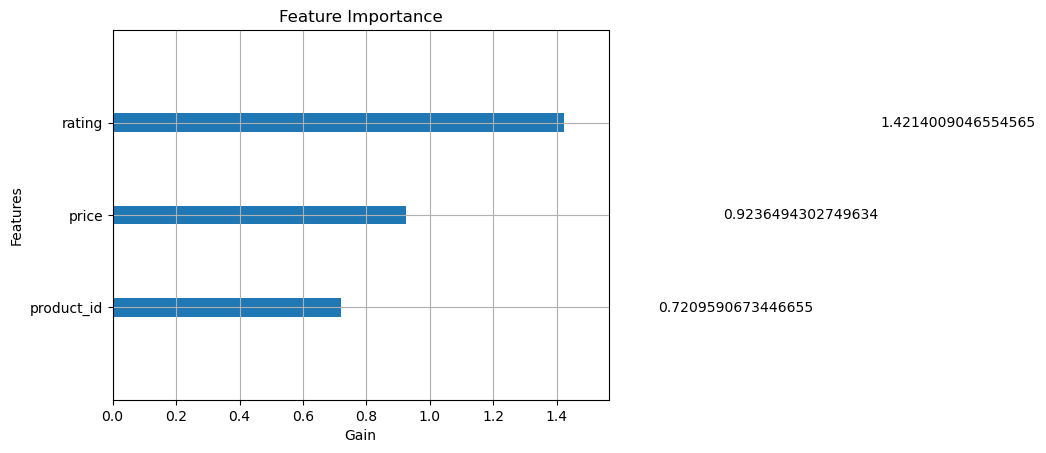

In [21]:
xgb.plot_importance(model,importance_type='gain',title="Feature Importance",xlabel="Gain")
plt.show()

In [22]:
def predict_return_risk(product_id,price,rating):
    product_code = label_encoder.transform([product_id])[0] if product_id in label_encoder.classes_ else -1
    input_df = pd.DataFrame([[product_code,price,rating]],columns=['product_id','price','rating'])
    prob = model.predict_proba(input_df)[0][1]
    risk = "high" if prob>=threshold else "Low"
    print(f"Predicted Return Risk: {risk}(Probability:{prob:.2f})")
predict_return_risk(product_id="P909",price=141.90,rating=3)

Predicted Return Risk: Low(Probability:0.14)


In [23]:
predict_return_risk(product_id="P255",price=453.40,rating=1)

Predicted Return Risk: high(Probability:1.00)


In [24]:
predict_return_risk(product_id="P235",price=85.44,rating=3)

Predicted Return Risk: high(Probability:0.89)


In [25]:
predict_return_risk(product_id="P130",price=255.96,rating=4)

Predicted Return Risk: high(Probability:0.90)


In [26]:
predict_return_risk(product_id="P493",price=50.16,rating=1)

Predicted Return Risk: Low(Probability:0.15)


In [27]:
predict_return_risk(product_id="p163",price=170.31,rating=4)

Predicted Return Risk: Low(Probability:0.03)


In [28]:
predict_return_risk(product_id="P264",price=366.1,rating=2)

Predicted Return Risk: high(Probability:0.97)
